# Introducción a Quantum Error Correction
Diego Hernández Rajkov

14 de Diciembre de 2016

## Corrección de errores en computación clásica




## Corrección de errores en computación cuántica

In [1]:
push!(LOAD_PATH, ".");
using quantum
using PyPlot

## Bit Flip Error

![Circuito Bit Flip](images/Quantum_error_correction_of_bit_flip_using_three_qubits.svg.png)

In [2]:
function concat_ancilla(psi::Array{Complex{Float64},2}, n::Int64)
    m = log2(length(psi))
    psi_anc = zeros(Complex{Float64}, Int(2^(n+m)),1)
    psi_anc[1:length(psi)] = psi
    return psi_anc
end

concat_ancilla (generic function with 1 method)

In [3]:
psi=random_state(2)

2x1 Array{Complex{Float64},2}:
  0.227396+0.85im    
 -0.412022-0.236702im

In [5]:
concat_ancilla(psi,2)

8x1 Array{Complex{Float64},2}:
  0.227396+0.85im    
 -0.412022-0.236702im
       0.0+0.0im     
       0.0+0.0im     
       0.0+0.0im     
       0.0+0.0im     
       0.0+0.0im     
       0.0+0.0im     

In [7]:
function apply_control_not!(psi::Array{Complex{Float64},2}, control_qubit::Int64, target_qubit::Int64)
    psi_i_temp = copy(psi)
    mov = max(control_qubit,target_qubit)
    for i = 0:length(psi)-1
        if testbit(i,control_qubit) & !testbit(i,target_qubit)
            psi[i+1] = psi_i_temp[i+1+2^mov]
        elseif testbit(i,control_qubit) & testbit(i,target_qubit)
            psi[i+1] = psi_i_temp[i+1-2^mov]
        end
    end
end

function apply_toffoli!(psi::Array{Complex{Float64},2}, control_qubit1::Int64, control_qubit2::Int64, target_qubit::Int64)
    psi_i_temp = copy(psi)
    mov = target_qubit
    for i = 0:length(psi)-1
        if testbit(i,control_qubit1) & testbit(i,control_qubit2) & !testbit(i,target_qubit)
            psi[i+1] = psi_i_temp[i+1+2^mov]
        elseif testbit(i,control_qubit1) & testbit(i,control_qubit2) & testbit(i,target_qubit)
            psi[i+1] = psi_i_temp[i+1-2^mov]
        end
    end
end

apply_toffoli! (generic function with 1 method)

In [8]:
function BitFlip_encoder(psi::Array{Complex{Float64},2})
    psi_encode = concat_ancilla(psi, 2)
    apply_control_not!(psi_encode, 0, 1)
    apply_control_not!(psi_encode, 0, 2)
    return psi_encode
end

BitFlip_encoder (generic function with 1 method)

In [ ]:
Bi

In [5]:
function Error_generator(Err, psi::Array{Complex{Float64},2}, p::Float64)
    n = Int(log2(length(psi)))
    psi_err = copy(psi)
    for i=0:n-1
        if rand()< p
            apply_unitary!(psi_err, Err, n-1-i)
        end
    end
    return psi_err
end

Error_generator (generic function with 1 method)

In [6]:
BitFlipStabilizerGroupeOp = Array[Array[sigma_z, sigma_z], Array[sigma_z, sigma_z]];
BitFlipStabilizerGroupeIdx = Array[[0 1],[0 2]];
BitFlipStabilizerCorrectionEig = Array[[-1;-1],[-1;1],[1;-1]];
BitFlipStabilizerCorrectionIdx = [0;1;2];

In [7]:
function BitFlipQEC(psi::Array{Complex{Float64},2})
    Eigenvals = zeros(Int64,length(BitFlipStabilizerGroupeIdx))
    
    for i in 1:length(BitFlipStabilizerGroupeIdx)
        psi_test = copy(psi)
        for j in 1:length(BitFlipStabilizerGroupeIdx[i])
            apply_unitary!(psi_test, BitFlipStabilizerGroupeOp[i][j], BitFlipStabilizerGroupeIdx[i][j])
        end
        if psi_test == psi
            Eigenvals[i] = 1
        elseif psi_test == -psi
            Eigenvals[i] = -1
        end 
    end
    
    psi_corr = copy(psi)
    for i in 1:length(BitFlipStabilizerCorrectionEig)
        if Eigenvals == BitFlipStabilizerCorrectionEig[i]
            apply_unitary!(psi_corr, sigma_x, BitFlipStabilizerCorrectionIdx[i])
        end
    end
    
    apply_control_not!(psi_corr, 0, 1)
    apply_control_not!(psi_corr, 0, 2)
    apply_toffoli!(psi_corr, 2, 1, 0)
    
    return psi_corr
end

BitFlipQEC (generic function with 1 method)

In [8]:
for i in 0:2
    psi = random_state(2)
    psi_enc = BitFlip_encoder(psi)
    
    apply_unitary!(psi_enc, sigma_x, i)
    
    psi_corr = BitFlipQEC(psi_enc)
    @show norm(psi - psi_corr[1:2])
end

norm(psi - psi_corr[1:2]) = 0.0
norm(psi - psi_corr[1:2]) = 0.0
norm(psi - psi_corr[1:2]) = 0.0


In [9]:
function CountCoincidenceBitPlip(p::Array{Float64,1}, case::AbstractString, N=10000)
    coincidences = SharedArray(Float64, length(p), init=0)
    n = 1
    for j in 1:length(p)
        for i=1:N
            psi = random_state(2)
            if case == "QEC"
                psi_enc = BitFlip_encoder(psi)
                psi_enc_err = Error_generator(sigma_x, psi_enc, p[j])
                psi_enc_corrected = BitFlipQEC(psi_enc_err)
                
                if norm(psi - psi_enc_corrected[1:2]) < 1e-6
                    coincidences[j] += 1.
                elseif norm(psi - psi_enc_corrected[1:2] - 2) < 1e-6
                    coincidences[j] += 1.
                end
            elseif case == "NoQEC"
                psi_err = Error_generator(sigma_x, psi, p[j])
                if psi == psi_err
                    coincidences[j] += 1.
                end
            end
        end
    end
    return coincidences/N
end

CountCoincidenceBitPlip (generic function with 2 methods)

In [10]:
p = collect(0:0.005:1)
BitFlipCountQEC = CountCoincidenceBitPlip(p, "QEC", 1e4);
BitFlipCountNoQEC = CountCoincidenceBitPlip(p, "NoQEC", 1e4);

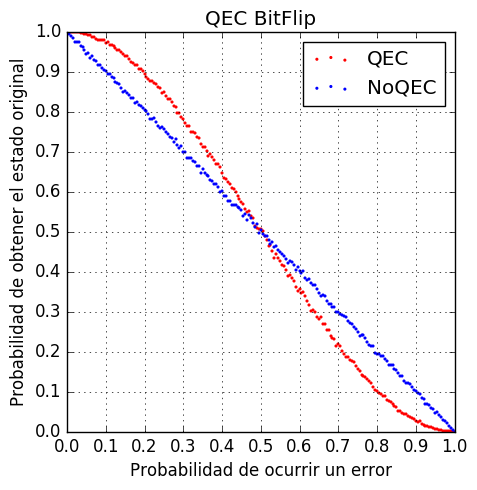

PyObject <matplotlib.text.Text object at 0x313342d10>

In [11]:
fig=figure(figsize=(5,5))
ax=subplot(1,1,1)
ax[:xaxis][:set_ticks](collect(0:0.1:1))
ax[:yaxis][:set_ticks](collect(0:0.1:1))
grid(true)

scatter(p, BitFlipCountQEC, c="r", s=5, lw=0, label="QEC")
scatter(p, BitFlipCountNoQEC, c="b", s=5, lw=0, label="NoQEC")
xlim([0,1]); ylim([0,1]); legend(loc=1);
xlabel("Probabilidad de ocurrir un error")
ylabel("Probabilidad de obtener el estado original")
title("QEC BitFlip")

## Phase Flip Error
![Circuito Bit Flip](images/Quantum_error_correction_of_phase_flip_using_three_qubits.svg.png)

In [9]:
hadamard = [1 1; 1 -1]/sqrt(2.);

In [13]:
function CountCoincidencePhasePlip(p::Array{Float64,1}, case::AbstractString, N=10000)
    coincidences = SharedArray(Float64, length(p), init=0)
    n = 1
    for j in 1:length(p)
        for i=1:N
            psi = random_state(2)
            if case == "QEC"
                psi_enc = BitFlip_encoder(psi)
                
                for i = 0:2
                    apply_unitary!(psi_enc, hadamard, i)
                end
                
                psi_enc_err = Error_generator(sigma_z, psi_enc, p[j])
                
                for i = 0:2
                    apply_unitary!(psi_enc_err, hadamard, i)
                end
                
                psi_enc_corrected = BitFlipQEC(psi_enc_err)
                
                if norm(psi - psi_enc_corrected[1:2]) < 1e-6
                    coincidences[j] += 1.
                elseif norm(psi - psi_enc_corrected[1:2] - 2) < 1e-6
                    coincidences[j] += 1.
                end
                
            elseif case == "NoQEC"
                psi_err = Error_generator(sigma_z, psi, p[j])
                if psi == psi_err
                    coincidences[j] += 1.
                end
            end
        end
    end
    return coincidences/N
end

CountCoincidencePhasePlip (generic function with 2 methods)

In [14]:
p = collect(0:0.005:1)
PhaseFlipCountQEC = CountCoincidencePhasePlip(p, "QEC", 1e4);
PhaseFlipCountNoQEC = CountCoincidencePhasePlip(p, "NoQEC", 1e4);

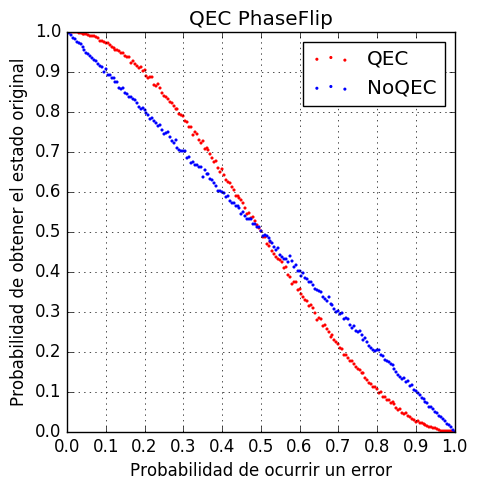

PyObject <matplotlib.text.Text object at 0x320c62410>

In [15]:
fig=figure(figsize=(5,5))
ax=subplot(1,1,1)
ax[:xaxis][:set_ticks](collect(0:0.1:1))
ax[:yaxis][:set_ticks](collect(0:0.1:1))
grid(true)

scatter(p, PhaseFlipCountQEC, c="r", s=5, lw=0, label="QEC")
scatter(p, PhaseFlipCountNoQEC, c="b", s=5, lw=0, label="NoQEC")
xlim([0,1]); ylim([0,1]); legend(loc=1);
xlabel("Probabilidad de ocurrir un error")
ylabel("Probabilidad de obtener el estado original")
title("QEC PhaseFlip")

## Código de Shor
![Circuito Shor Code](images/Shore_code.svg.png)

In [16]:
function Shor_encoder(psi::Array{Complex{Float64},2})
    psi_encode = concat_ancilla(psi, 8)
    apply_control_not!(psi_encode, 0, 3)
    apply_control_not!(psi_encode, 0, 6)

    for i in 0:2
        apply_unitary!(psi_encode, hadamard, 3*i)
    end
    for i in 0:2
        apply_control_not!(psi_encode, 3*i, 3*i+1)
    end
    for i in 0:2
        apply_control_not!(psi_encode, 3*i, 3*i+2)
    end
    return psi_encode
end

Shor_encoder (generic function with 1 method)

In [17]:
ShorStabilizerGroupeOp = Array[ sigma_z, sigma_z, sigma_z, sigma_z,
                            sigma_z, sigma_z, sigma_x, sigma_x]
ShorStabilizerGroupeIdx = Array[[1 0],[2 1],[4 3],[5 4],[7 6],[8 7],[5 4 3 2 1 0],[8 7 6 5 4 3]]

ShorBitFlipStabilizerCorrectionEig = Array[
    [-1; 1; 1; 1; 1; 1],
    [-1; -1; 1; 1; 1; 1],
    [1; -1; 1; 1; 1; 1],
    [1; 1; -1; 1; 1; 1],
    [1; 1; -1; -1; 1; 1],
    [1; 1; 1; -1; 1; 1],
    [1; 1; 1; 1; -1; 1],
    [1; 1; 1; 1; -1; -1],
    [1; 1; 1; 1; 1; -1]
]
ShorBitFlipStabilizerCorrectionIdx = [0;1;2;3;4;5;6;7;8]

ShorPhaseFlipStabilizerCorrectionEig = Array[[-1;1], [-1;-1], [1;-1]]
ShorPhaseFlipStabilizerCorrectionIdx = Array[[0 1 2], [3 4 5], [6 7 8]];

In [18]:
function ShorCodeQEC(psi::Array{Complex{Float64},2})
    Eigenvals = zeros(Int64,length(ShorStabilizerGroupeIdx))
    
    for i in 1:length(ShorStabilizerGroupeIdx)
        psi_test = copy(psi)
        for j in 1:length(ShorStabilizerGroupeIdx[i])
            apply_unitary!(psi_test, ShorStabilizerGroupeOp[i], ShorStabilizerGroupeIdx[i][j])
        end
        if psi_test == psi
            Eigenvals[i] = 1
        elseif psi_test == -psi
            Eigenvals[i] = -1
        end 
    end
    
    psi_corr = copy(psi)
    for i in 1:length(ShorBitFlipStabilizerCorrectionEig)
        if Eigenvals[1:6] == ShorBitFlipStabilizerCorrectionEig[i]
            apply_unitary!(psi_corr, sigma_x, ShorBitFlipStabilizerCorrectionIdx[i])
        end
    end
    for i in 1:length(ShorPhaseFlipStabilizerCorrectionEig)
        if Eigenvals[7:8] == ShorPhaseFlipStabilizerCorrectionEig[i]
            for j in 1:3  
                apply_unitary!(psi_corr, sigma_z, ShorPhaseFlipStabilizerCorrectionIdx[i][j])
            end
        end
    end
    
    for i in 0:2
        apply_control_not!(psi_corr, 3*i, 3*i+1)
    end
    
    for i in 0:2
        apply_control_not!(psi_corr, 3*i, 3*i+2)
    end
    
    for i in 0:2
        apply_toffoli!(psi_corr, 3*i+2, 3*i+1, 3*i)
    end
    
    for i in 0:2
        apply_unitary!(psi_corr, hadamard, 3*i)
    end
    
    apply_control_not!(psi_corr, 0, 6)
    apply_control_not!(psi_corr, 0, 3)
    apply_toffoli!(psi_corr, 6, 3, 0)
    
    return psi_corr
end

ShorCodeQEC (generic function with 1 method)

In [19]:
for i in 0:8
    psi = random_state(2)
    psi_enc = Shor_encoder(psi)
    apply_unitary!(psi_enc, sigma_z, i)
    psi_corr = SrhorCodeQEC(psi_enc)
    
    @show norm(psi_corr[1:2]-psi)
end

norm(psi_corr[1:2] - psi) = 5.606351459942525e-16
norm(psi_corr[1:2] - psi) = 7.005202656181568e-16
norm(psi_corr[1:2] - psi) = 5.613217783960923e-16
norm(psi_corr[1:2] - psi) = 3.850929832103114e-16
norm(psi_corr[1:2] - psi) = 4.933939044724272e-16
norm(psi_corr[1:2] - psi) = 5.091937929346072e-16
norm(psi_corr[1:2] - psi) = 6.423257291564425e-16
norm(psi_corr[1:2] - psi) = 5.057306561942087e-16
norm(psi_corr[1:2] - psi) = 3.7238012298709097e-16


In [20]:
for i in 0:8
    psi = random_state(2)
    psi_enc = Shor_encoder(psi)
    apply_unitary!(psi_enc, sigma_x, i)
    psi_corr = ShorCodeQEC(psi_enc)
    
    @show norm(psi_corr[1:2]-psi)
end

norm(psi_corr[1:2] - psi) = 6.661338147750939e-16
norm(psi_corr[1:2] - psi) = 5.613217783960923e-16
norm(psi_corr[1:2] - psi) = 5.214799211354908e-16
norm(psi_corr[1:2] - psi) = 4.041272810440265e-16
norm(psi_corr[1:2] - psi) = 5.4672143489065705e-16
norm(psi_corr[1:2] - psi) = 5.715222817774257e-16
norm(psi_corr[1:2] - psi) = 5.324442579404919e-16
norm(psi_corr[1:2] - psi) = 6.255789036560346e-16
norm(psi_corr[1:2] - psi) = 5.628636387720389e-16


In [21]:
for i in 0:8
    psi = random_state(2)
    psi_enc = Shor_encoder(psi)
    apply_unitary!(psi_enc, sigma_x, i)
    apply_unitary!(psi_enc, sigma_z, i)
    psi_corr = ShorCodeQEC(psi_enc)
    
    @show norm(psi_corr[1:2]-psi)
end

norm(psi_corr[1:2] - psi) = 1.9999999999999993
norm(psi_corr[1:2] - psi) = 1.9999999999999993
norm(psi_corr[1:2] - psi) = 1.9999999999999996
norm(psi_corr[1:2] - psi) = 1.9999999999999993
norm(psi_corr[1:2] - psi) = 1.9999999999999996
norm(psi_corr[1:2] - psi) = 1.9999999999999998
norm(psi_corr[1:2] - psi) = 1.9999999999999993
norm(psi_corr[1:2] - psi) = 1.9999999999999993
norm(psi_corr[1:2] - psi) = 1.9999999999999993


In [22]:
function CountCoincidenceShorCode(p::Array{Float64,1}, case::AbstractString, N=10000)
    coincidences = SharedArray(Float64, length(p), init=0)
    n = 1
    for j in 1:length(p)
        for i=1:N
            psi = random_state(2)
            if case == "QEC"
                psi_enc = Shor_encoder(psi)
                psi_enc_err1 = Error_generator(sigma_x, psi_enc, p[j])
                psi_enc_err2 = Error_generator(sigma_z, psi_enc_err1, p[j])
                
                psi_enc_corrected = ShorCodeQEC(psi_enc_err2)
                
                if norm(psi - psi_enc_corrected[1:2]) < 1e-6
                    coincidences[j] += 1.
                elseif norm(psi - psi_enc_corrected[1:2] - 2) < 1e-6
                    coincidences[j] += 1.
                end
            elseif case == "NoQEC"
                psi_err = Error_generator(sigma_x, psi, p[j])
                psi_enc_err = Error_generator(sigma_z, psi_err, p[j])
                if psi == psi_en2c_err
                    coincidences[j] += 1.
                end
            end
        end
    end
    return coincidences/N
end

CountCoincidenceShorCode (generic function with 2 methods)

In [23]:
p = collect(0:0.01:1)
ShorCodeCountQEC = CountCoincidenceShorCode(p, "QEC", 1e4);
ShorCodeCountNoQEC = CountCoincidenceShorCode(p, "NoQEC", 1e4);

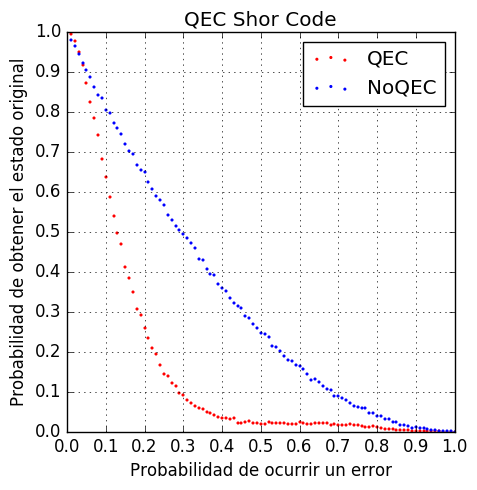

PyObject <matplotlib.text.Text object at 0x313456090>

In [24]:
fig = figure(figsize=(5,5))
ax = subplot(1,1,1)
ax[:xaxis][:set_ticks](collect(0:0.1:1))
ax[:yaxis][:set_ticks](collect(0:0.1:1))
grid(true)

scatter(p, ShorCodeCountQEC, c="r", s=5, lw=0, label="QEC")
scatter(p, ShorCodeCountNoQEC, c="b", s=5, lw=0, label="NoQEC")
xlim([0,1]); ylim([0,1]); legend(loc=1)
xlabel("Probabilidad de ocurrir un error")
ylabel("Probabilidad de obtener el estado original")
title("QEC Shor Code")

In [25]:
p_fine = 0.06*collect(0:0.01:1)
ShorCodeCountQEC_fine = CountCoincidenceShorCode(p_fine, "QEC", 1e4);
ShorCodeCountNoQEC_fine = CountCoincidenceShorCode(p_fine, "NoQEC", 1e4);

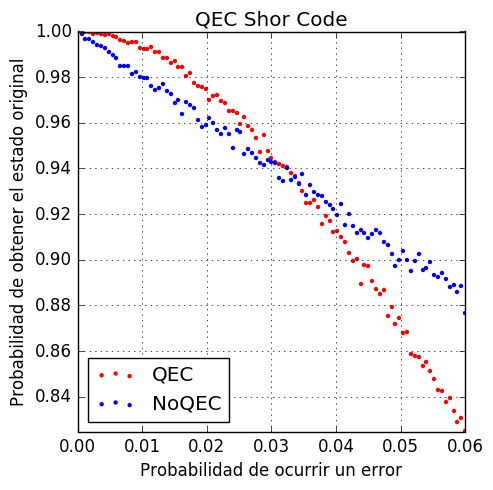

PyObject <matplotlib.text.Text object at 0x320dc6090>

In [26]:
max_x = maximum(p_fine)
min_y = min(minimum(ShorCodeCountQEC_fine), minimum(ShorCodeCountNoQEC_fine))

fig = figure(figsize=(5,5))
ax = subplot(1,1,1)
ax[:xaxis][:set_ticks](collect(0:1e-2:max_x))
ax[:yaxis][:set_ticks](collect(floor(100*min_y)/100:2e-2:1))
grid(true)

scatter(p_fine, ShorCodeCountQEC_fine, c="r", s=10, lw=0, label="QEC")
scatter(p_fine, ShorCodeCountNoQEC_fine, c="b", s=10, lw=0, label="NoQEC")
xlim([0,max_x]); ylim([min_y,1]); legend(loc=3);
xlabel("Probabilidad de ocurrir un error")
ylabel("Probabilidad de obtener el estado original")
title("QEC Shor Code")

## Concatenation of Bit Flip code

![Circuito Bit Flip](images/BitConcat.png)

In [27]:
function Concat_BitFlip_encoder(psi::Array{Complex{Float64},2}, depth::Int64)
    psi_encode = concat_ancilla(psi, 3^depth-1)
    
    for d in 0:depth-1
        for b in 0:(3^d-1)
            for k in 0:1
                apply_control_not!(psi_encode, 3^(depth-d)*b, 3^(depth-d)*b+3^(depth-1-d)*2^k)
            end
        end
    end

    return psi_encode
end

Concat_BitFlip_encoder (generic function with 1 method)

In [28]:
function Concat_BitFlipQEC(psi::Array{Complex{Float64},2}, depth::Int64)
    psi_corr = copy(psi)
    
    qubits = zeros(Int, 3)
    for d in depth-1:-1:0
        for b in 0:(3^d-1)
            qubits[1] = 3^(depth-d)*b
            qubits[2] = 3^(depth-d)*b+3^(depth-1-d)
            qubits[3] = 3^(depth-d)*b+3^(depth-1-d)*2
            
            Eigenvals = zeros(Int64,length(BitFlipStabilizerGroupeIdx))
            for i in 1:length(BitFlipStabilizerGroupeIdx)
                psi_test = copy(psi_corr)
                for j in 1:length(BitFlipStabilizerGroupeIdx[i])
                    apply_unitary!(psi_test, BitFlipStabilizerGroupeOp[i][j], qubits[1+BitFlipStabilizerGroupeIdx[i][j]])
                end
                if psi_test == psi_corr
                    Eigenvals[i] = 1
                elseif psi_test == -psi_corr
                    Eigenvals[i] = -1
                end 
            end
            
            for i in 1:length(BitFlipStabilizerCorrectionEig)
                if Eigenvals == BitFlipStabilizerCorrectionEig[i]
                    apply_unitary!(psi_corr, sigma_x, qubits[1+BitFlipStabilizerCorrectionIdx[i]])
                end
            end

            apply_control_not!(psi_corr, qubits[1], qubits[2])
            apply_control_not!(psi_corr, qubits[1], qubits[3])
            apply_toffoli!(psi_corr, qubits[3], qubits[2], qubits[1])

        end
    end
    
    return psi_corr
end

Concat_BitFlipQEC (generic function with 1 method)

In [29]:
depth = 1
for i in 0:3^depth-1
    psi = random_state(2)
    psi_enc = Concat_BitFlip_encoder(psi, depth);

    apply_unitary!(psi_enc, sigma_x, i)

    psi_corr = Concat_BitFlipQEC(psi_enc, depth)
    
    @show norm(psi-psi_corr[1:2])
end

norm(psi - psi_corr[1:2]) = 0.0
norm(psi - psi_corr[1:2]) = 0.0
norm(psi - psi_corr[1:2]) = 0.0


In [30]:
depth = 2
for i in 0:3^depth-1
    psi = random_state(2)
    psi_enc = Concat_BitFlip_encoder(psi, depth);

    apply_unitary!(psi_enc, sigma_x, i)

    psi_corr = Concat_BitFlipQEC(psi_enc, depth)
    
    @show norm(psi-psi_corr[1:2])
end

norm(psi - psi_corr[1:2]) = 0.0
norm(psi - psi_corr[1:2]) = 0.0
norm(psi - psi_corr[1:2]) = 0.0
norm(psi - psi_corr[1:2]) = 0.0
norm(psi - psi_corr[1:2]) = 0.0
norm(psi - psi_corr[1:2]) = 0.0
norm(psi - psi_corr[1:2]) = 0.0
norm(psi - psi_corr[1:2]) = 0.0
norm(psi - psi_corr[1:2]) = 0.0


In [31]:
function CountCoincidenceConcatBitFlip(p::Array{Float64,1}, case::AbstractString, 
    N=10000, depth=1)
    
    coincidences = SharedArray(Float64, length(p), init=0)
    n = 1
    for j in 1:length(p)
        for i=1:N
            psi = random_state(2)
            if case == "QEC"
                psi_enc = Concat_BitFlip_encoder(psi, depth)
                psi_enc_err = Error_generator(sigma_x, psi_enc, p[j])
                psi_enc_corrected = Concat_BitFlipQEC(psi_enc_err, depth)
                
                if norm(psi - psi_enc_corrected[1:2]) < 1e-6
                    coincidences[j] += 1.
                end
            elseif case == "NoQEC"
                psi_err = Error_generator(sigma_x, psi, p[j])
                if psi == psi_err
                    coincidences[j] += 1.
                end
            end
        end
    end
    return coincidences/N
end

CountCoincidenceConcatBitFlip (generic function with 3 methods)

In [35]:
p = collect(0:0.01:1)
ConcatBitFlipCountQEC_1 = CountCoincidenceConcatBitFlip(p, "QEC", 1e4, 1);
ConcatBitFlipCountQEC_2 = CountCoincidenceConcatBitFlip(p, "QEC", 1e4, 2);
ConcatBitFlipCountNoQEC = CountCoincidenceConcatBitFlip(p, "NoQEC", 1e4);

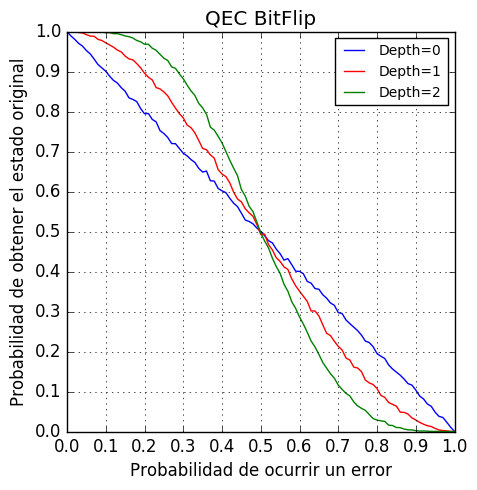

PyObject <matplotlib.text.Text object at 0x3217be450>

In [36]:
fig=figure(figsize=(5,5))
ax=subplot(1,1,1)
ax[:xaxis][:set_ticks](collect(0:0.1:1))
ax[:yaxis][:set_ticks](collect(0:0.1:1))
grid(true)

plot(p, ConcatBitFlipCountNoQEC, c="b", label="Depth=0")
plot(p, ConcatBitFlipCountQEC_1, c="r", label="Depth=1")
plot(p, ConcatBitFlipCountQEC_2, c="g", label="Depth=2")

xlim([0,1]); ylim([0,1]); legend(fontsize=10);
xlabel("Probabilidad de ocurrir un error")
ylabel("Probabilidad de obtener el estado original")
title("QEC BitFlip")

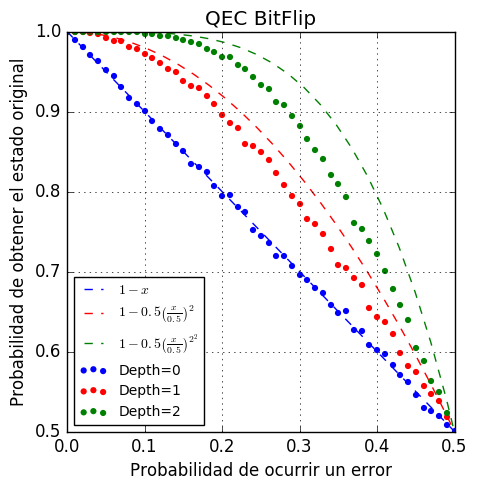

PyObject <matplotlib.text.Text object at 0x4a4935810>

In [62]:
x = linspace(0,1,50)
ph = 0.5

y0 = 1-x
y1 = 1-ph*(x/ph).^2
y2 = 1-ph*(x/ph).^(2^2)

fig=figure(figsize=(5,5))
ax=subplot(1,1,1)
ax[:xaxis][:set_ticks](collect(0:0.1:1))
ax[:yaxis][:set_ticks](collect(0:0.1:1))
grid(true)

scatter(p, ConcatBitFlipCountNoQEC, c="b", lw=0, label="Depth=0")
plot(x, y0, "b--", label="\$1-x\$")
scatter(p, ConcatBitFlipCountQEC_1, c="r", lw=0, label="Depth=1")
plot(x, y1, "r--", label="\$1-0.5\\left(\\frac\{x\}\{0.5\}\\right)^\{2\}\$")
scatter(p, ConcatBitFlipCountQEC_2, c="g", lw=0, label="Depth=2")
plot(x, y2, "g--", label="\$1-0.5\\left(\\frac\{x\}\{0.5\}\\right)^\{2^2\}\$")

xlim([0,0.5]); ylim([0.5,1]); legend(loc=3,fontsize=10);
xlabel("Probabilidad de ocurrir un error")
ylabel("Probabilidad de obtener el estado original")
title("QEC BitFlip")

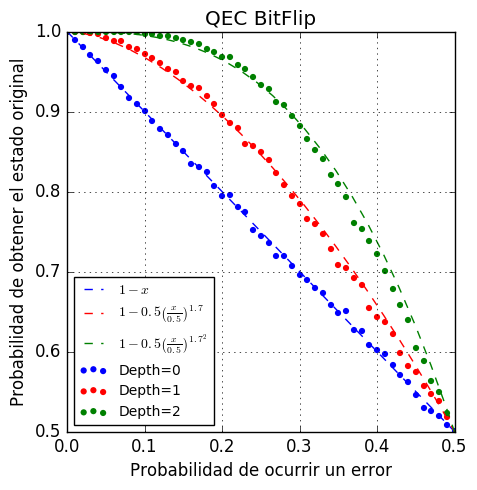

PyObject <matplotlib.text.Text object at 0x4a4d3c5d0>

In [64]:
x = linspace(0,1,50)
ph = 0.5

y0 = 1-x
y1 = 1-ph*(x/ph).^1.7
y2 = 1-ph*(x/ph).^(1.7^2)

fig=figure(figsize=(5,5))
ax=subplot(1,1,1)
ax[:xaxis][:set_ticks](collect(0:0.1:1))
ax[:yaxis][:set_ticks](collect(0:0.1:1))
grid(true)

scatter(p, ConcatBitFlipCountNoQEC, c="b", lw=0, label="Depth=0")
plot(x, y0, "b--", label="\$1-x\$")
scatter(p, ConcatBitFlipCountQEC_1, c="r", lw=0, label="Depth=1")
plot(x, y1, "r--", label="\$1-0.5\\left(\\frac\{x\}\{0.5\}\\right)^\{1.7\}\$")
scatter(p, ConcatBitFlipCountQEC_2, c="g", lw=0, label="Depth=2")
plot(x, y2, "g--", label="\$1-0.5\\left(\\frac\{x\}\{0.5\}\\right)^\{1.7^2\}\$")

xlim([0,0.5]); ylim([0.5,1]); legend(loc=3,fontsize=10);
xlabel("Probabilidad de ocurrir un error")
ylabel("Probabilidad de obtener el estado original")
title("QEC BitFlip")